# Analyzing SOFC data (part 6)

##6) Adding the temperature dimension
D\* and k\* are both thermally activated coefficients, meaning they are always much higher at higher temperatures. Diffusion at low temperatures is much slower because atoms vibrate with lower amplitude and this makes it tougher for ions to flow through the crystals. However, low temperatures are much more practical from an engineering standpoint because the stress on the systems is much lower and mechanical failure takes much longer to arise.

In this notebook I will extend my model, currently only analyzed at 1000K, to lower temperatures and see how well it holds up.

In [6]:
from sofc_func import *
%matplotlib inline

In [17]:
# Import using pandas
df = pd.read_csv("data.csv")

# Clean out rows where there is no parent A or parent B

data = df[pd.notnull(df['A_par']) & pd.notnull(df['B_par']) & pd.notnull(df['d_star']) & pd.notnull(df['k_star']) 
             & pd.notnull(df['e affinity(B)']) & pd.notnull(df['d-electron count (B)'])]

pd.options.mode.chained_assignment = None

data = features(df)

temps = [400,500,600,700,800,900,1000]
for i in temps:
    data['dk_'+str(i)] = pd.Series(dk_star(data,i), index=df.index)

f = data[pd.notnull(data['EA_A']) & pd.notnull(data['EA_B']) & pd.notnull(data['r_A'])
        & pd.notnull(data['r_B']) & pd.notnull(data['d_count_B']) & pd.notnull(data['avg_EA_A'])
        & pd.notnull(data['avg_EA_B']) & pd.notnull(data['avg_r_A']) & pd.notnull(data['avg_r_B'])
        & pd.notnull(data['avg_d_count_B']) & pd.notnull(data['dk_'+str(temps[0])]) ]

#Sort by avg_EA_B
f = f.sort(['avg_EA_B'])

In [8]:
def get_predictions(iterations, len_data, k, order, X, Y):
    predictions = []
    for cycle in range(iterations):
        cycle_predictions = []
        lko = cross_validation.KFold(len_data, n_folds=k, shuffle=True)
        for train_index, test_index in lko:
            x_train, x_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            model = make_pipeline(PolynomialFeatures(order), Ridge()).fit(x_train, y_train)
            cycle_predictions.append(model.predict(X))
        predictions.append(np.mean(np.array(cycle_predictions), axis=0))
    p = np.mean(np.array(predictions), axis=0)
    return p

###Model performance as a function of temperature:
I will run several model performance appraisals at temperatures 400-1000K and plot the results.

In [14]:
scores = []
stds = []
X = f[['avg_EA_B']]
models = {}
d_star = {}
k_star = {}

iterations = 600

start = time.clock()
for i in temps:
    y = f['dk_'+str(i)]
    k = optimize_k(iterations, len(y), np.array(X), np.array(y), True)
    o = optimize_order(iterations,len(y), k, np.array(X), np.array(y), True)
    score, std = get_scores(iterations, k, o, len(y), np.array(X), np.array(y), True)
    scores.append(score)
    stds.append(std)
    print 'Temperature: '+ str(i)+ ' Polynomial order: '+ str(o) + ' Score: ' + str(score) + ' +/- ' + str(std)
    models[str(i)] = get_predictions(iterations, len(y), k, o, np.array(X), np.array(y))
print 'Executed in ' + str(time.clock()-start) + 's'

Temperature: 400 Polynomial order: 3 Score: 0.597891433085 +/- 0.0435900865009
Temperature: 500 Polynomial order: 5 Score: 0.640026074195 +/- 0.0401430744254
Temperature: 600 Polynomial order: 5 Score: 0.680600349004 +/- 0.034901807809
Temperature: 700 Polynomial order: 7 Score: 0.723162238172 +/- 0.0268092506132
Temperature: 800 Polynomial order: 5 Score: 0.753516194761 +/- 0.0234012459971
Temperature: 900 Polynomial order: 7 Score: 0.76359004779 +/- 0.0227157227126
Temperature: 1000 Polynomial order: 5 Score: 0.727808746561 +/- 0.0265488983967
Executed in 277.379789s


Unlike the models in previous notebooks, these have a high polynomial order. 8th order polynomial functions are not physical, but remember that the regularization smooths these functions so they may resemble something meaningful. I am not sure why these are higher order, but let's plot them and take a look.

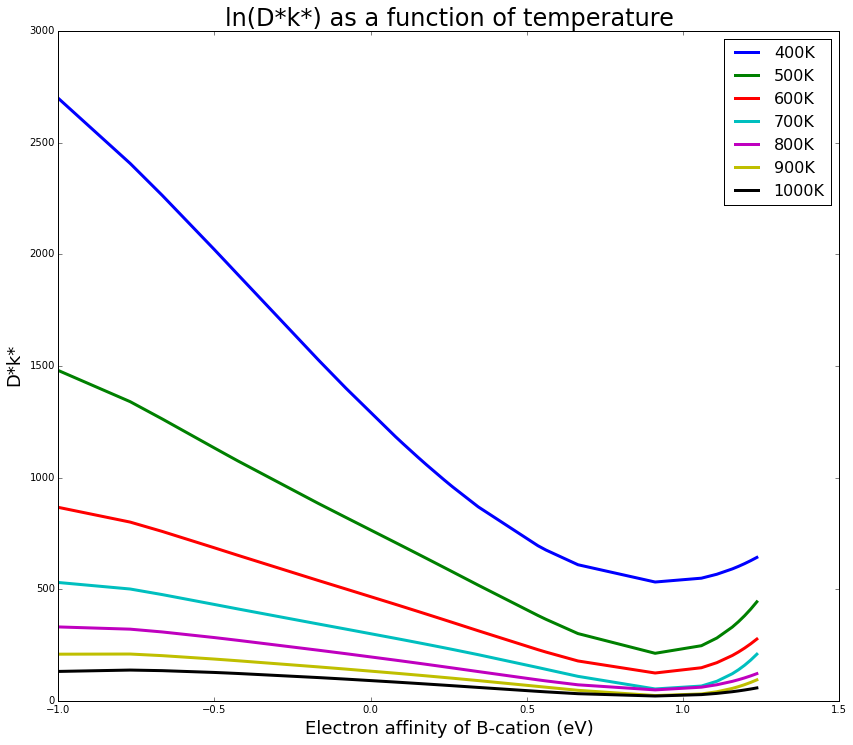

In [16]:
labels = []
plt.figure(figsize=(14,12))
for temp in temps:
    plt.plot(X, models[str(temp)], label=str(temp)+'K', linewidth=3)
    plt.ylabel('D*k*', fontsize=18)
    plt.xlabel('Electron affinity of B-cation (eV)', fontsize=18)
    plt.title('ln(D*k*) as a function of temperature', fontsize=24)
    labels.append(str(temp)+'K')
plt.legend(labels, fontsize=16)
plt.show()

This is still consistent with what I saw earlier: at 800-1000K, the function looks like a 3rd order polynomial. At higher temperatures, it looks more quadratic, with a flatter tail at lower electron affinities.

* **At all temperatures, D\*k\* reaches a minimum at ~1 eV average electron affinity of the B-site cation.**
* At lower temperatures, the increase is steeper and the minimum is a higher value of D\*k\*. This is consistent for thermally activated behavior.
* D\*k\* increases more sharply going >1 eV than going lower 


###Plotting model scores:

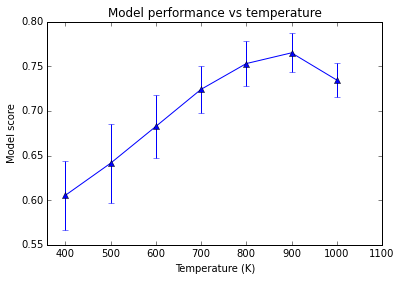

In [31]:
plt.errorbar(temps, scores, stds, marker='^')
plt.xlim(0.9*np.min(temps), 1.1*np.max(temps) )
plt.xlabel('Temperature (K)')
plt.ylabel('Model score')
plt.title('Model performance vs temperature')
plt.show()

From this we can see that the model's performance is indeed a function of temperature (so is the standard deviation). The model doesn't do as well at lower temperatures and peaks at 900K, which is in the high temperature range. The goal of this analysis is to describe diffusion at 400-700K so what can we do about the relatively poor performance and high standard deviations?

Let's take another crack at adding variables at lower temperatures.

##400K:

###Empty model:

In [3]:
y = f['dk_400']
_features = f[ ['avg_EA_A', 'avg_r_A','avg_r_B', 'tol_factor', 'r_critical', 'avg_EA_B', 'avg_d_count_B' ]]

new = add_feature(None, np.array([y]).T, _features, 0.1, 100)

-0.0386714094146 avg_EA_A
0.0755373006156 avg_r_A
-0.0416011444547 avg_r_B
0.0374139763774 tol_factor
0.0314525324075 r_critical
0.600846013786 avg_EA_B
0.445714254592 avg_d_count_B
The best feature to start with is avg_EA_B with a score of 0.600846013786


###With avg_EA_B

In [4]:
new2 = add_feature(new, np.array([y]).T, _features, 0.1, 100)

Determining if a feature can be added. This may take a few minutes.
Could not add avg_EA_A to the model because its change on score was -0.0063422066524 (7.70569s)
Could not add avg_r_A to the model because its change on score was 0.000941457923248 (6.679483s)
Could not add avg_r_B to the model because its change on score was 0.00131067422873 (8.536743s)
Could not add tol_factor to the model because its change on score was -0.00738504791232 (5.822709s)
Could not add r_critical to the model because its change on score was -0.00845158928733 (7.05812s)
Could not add avg_EA_B to the model because its change on score was -0.000793426588604 (5.539531s)
Could not add avg_d_count_B to the model because its change on score was -0.0237961676014 (5.792184s)
Could not add any features to the model.
Executed in  52.371921 s


Same story as with 1000K. It looks like none of the features I have will help.

##600K:

In [5]:
y = f['dk_600']
new = add_feature(None, np.array([y]).T, _features, 0.1, 100)

-0.0114781556459 avg_EA_A
0.101280393949 avg_r_A
-0.0548403224372 avg_r_B
0.0320190054372 tol_factor
0.0320613391071 r_critical
0.677019123253 avg_EA_B
0.541691550247 avg_d_count_B
The best feature to start with is avg_EA_B with a score of 0.677019123253


In [6]:
new2 = add_feature(new, np.array([y]).T, _features, 0.1, 100)

Determining if a feature can be added. This may take a few minutes.
Could not add avg_EA_A to the model because its change on score was 0.0121801722877 (7.720357s)
Could not add avg_r_A to the model because its change on score was -0.00673381320086 (6.723999s)
Could not add avg_r_B to the model because its change on score was 0.0101439612125 (7.762797s)
Could not add tol_factor to the model because its change on score was 0.00601117348901 (7.969694s)
Could not add r_critical to the model because its change on score was 0.00149634506425 (6.999189s)
Could not add avg_EA_B to the model because its change on score was 0.00781612278089 (6.34168s)
Could not add avg_d_count_B to the model because its change on score was -0.00748565520853 (8.922765s)
Could not add any features to the model.
Executed in  59.030606 s


###No dice.

One last piece to the analysis is plotting the model as a function of temperature. Since there is only one feature, I will just plot a series of functions in 2D.

#Conclusion:
Across all temperatures, average electron affinity of the B-site cation is the best indicator of diffusion. D\*\k\* is best modeled with a 3rd order, regularized polynomial function of avg_EA_B. The model, however, performs best from 700-1000K and loses insight at temperature much below that.

The loss in predictability may come from the fact that most of the measured values are extrapolated from measurements at higher temperatures. The Arrhenius behaviour should theoretically extend predictions to all temperatures, but phase changes, microstructures, and defects make this a bit unrealistic.

As for the peak performance of this model, roughly 25% of the variation is left unexplained and none of the other features in this analysis were able to shed significant, additional insight. This comes from the difficult nature of this problem. There are many, many environmental and material factors affecting each measurement that go beyond composition of the material itself, which is the only factor from which these features were derived.

##In summary...
#####Electron affinity of the B-site cation is a reasonably good predictor of overall diffusion rates in Solid Oxide Fuel Cell cathode materials. Using materials with higher average electron affinities will lead to faster oxide diffusion through the materials, owing to the fact that such cations may be reduced by free oxygen atoms and give rise to higher concentrations of oxide ions. At lower temperatures, this is not as effective a method, as performance becomes more dominated by intangible measurement factors rather than material characteristics.